# 读取df里面的输入来计算卫星的俯仰角以及方位角


In [1]:
# 导入需要用到的函数库
import pandas as pd
import numpy as np
import math
import matlab.engine
import os
import time
import matplotlib.pyplot as plt

In [ ]:
def qv_python():
    """
    Python implementation of qv.m
    
    读取文本文件中的数据，并使用qv_kinematics函数计算方位角和俯仰角
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.spatial.transform import Rotation as R
    
    # 读取文本文件
    try:
        # 尝试使用pandas读取文件
        data1 = pd.read_csv('./12.12.1.txt', delim_whitespace=True, header=None)
        data1 = data1.values  # 转换为numpy数组
    except Exception as e:
        print(f"使用pandas读取文件失败: {e}")
        # 备选方案：使用numpy直接读取
        try:
            data1 = np.loadtxt('12.12.1.txt')
        except Exception as e2:
            print(f"使用numpy读取文件失败: {e2}")
            # 如果文件格式特殊，手动读取
            data1 = []
            with open('./12.12.1.txt', 'r') as f:
                for line in f:
                    values = [float(x) for x in line.strip().split()]
                    data1.append(values)
            data1 = np.array(data1)
    
    print("读取的数据:")
    print(data1)
    
    # 定义安装矩阵
    QV_1_ZH07_Z01_01 = np.array([
        [0.985381744558545, -0.170360844946125, -0.000429350982799],
        [0.170360844946125, 0.985381744558545, 0.000312413931025],
        [0.000370009792980, -0.000382227096880, 0.999999858314826]
    ])
    
    # 使用scipy创建旋转矩阵，相当于MATLAB中的rotz(-60)
    QV_2_ZH09_Z01_01 = R.from_euler('z', -60, degrees=True).as_matrix()
    
    # 初始化结果数组
    s = data1.shape[0]
    faip = np.zeros(s)
    thetap = np.zeros(s)
    
    # 对每行数据调用qv_kinematics函数
    for i in range(s):
        faip[i], thetap[i] = qv_kinematics(data1[i, 0], data1[i, 1], QV_2_ZH09_Z01_01)
    
    # 显示结果
    print("\n计算结果:")
    results = pd.DataFrame({
        'thetay': data1[:, 0],
        'thetax': data1[:, 1],
        '方位角(faip)': faip,
        '俯仰角(thetap)': thetap
    })
    print(results)
    
    # 可视化结果
    plt.figure(figsize=(12, 8))
    
    # 方位角
    plt.subplot(2, 1, 1)
    plt.plot(faip, 'r-o', label='方位角')
    plt.title('方位角 (Azimuth)')
    plt.xlabel('数据点')
    plt.ylabel('角度 (度)')
    plt.grid(True)
    plt.legend()
    
    # 俯仰角
    plt.subplot(2, 1, 2)
    plt.plot(thetap, 'b-o', label='俯仰角')
    plt.title('俯仰角 (Elevation)')
    plt.xlabel('数据点')
    plt.ylabel('角度 (度)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 极坐标可视化
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, projection='polar')
    # 转换为弧度并调整方向
    theta = np.radians(faip)
    r = 90 - thetap  # 将俯仰角转换为极坐标半径
    
    ax.scatter(theta, r, c='red', s=50, alpha=0.7)
    ax.set_title('方位角和俯仰角的极坐标表示', va='bottom')
    ax.set_theta_zero_location('N')  # 北方向为0度
    ax.set_theta_direction(-1)  # 顺时针方向
    ax.set_rlim(0, 90)
    ax.set_rticks([0, 15, 30, 45, 60, 75, 90])
    ax.set_rlabel_position(0)
    ax.grid(True)
    
    plt.show()
    
    return faip, thetap, data1

# 执行函数
# try:
#     faip, thetap, data1 = qv_python()
#     print("函数执行成功!")
# except Exception as e:
#     print(f"函数执行失败: {e}")
#     import traceback
#     traceback.print_exc()

In [ ]:
# 添加MATLAB与Python实现的qv.m结果对比函数

def compare_qv_implementations():
    """
    比较Python实现的qv.m与MATLAB原始qv.m的结果
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matlab.engine
    from scipy.spatial.transform import Rotation as R
    
    print("开始比较Python和MATLAB的qv.m实现...")
    
    # 1. 获取Python实现的结果
    try:
        faip_py, thetap_py, data1_py = qv_python()
        print("Python实现执行成功!")
    except Exception as e:
        print(f"Python实现执行失败: {e}")
        import traceback
        traceback.print_exc()
        return
    
    # 2. 获取MATLAB原始实现的结果
    try:
        print("启动MATLAB引擎...")
        eng = matlab.engine.start_matlab()
        eng.addpath(r'd:\CODE\HealthSoftware\角度code\角度code\角度code')
        
        print("调用MATLAB的qv.m...")
        # 调用MATLAB的qv.m并获取结果
        # 注意：如果qv.m没有返回值，需要修改MATLAB代码或使用其他方式获取结果
        try:
            # 尝试直接调用qv.m
            faip_matlab, thetap_matlab = eng.qv(nargout=2)
            matlab_results_available = True
        except Exception as e1:
            print(f"直接调用MATLAB的qv.m失败: {e1}")
            print("尝试创建临时MATLAB函数来获取qv.m的结果...")
            
            # 创建临时MATLAB函数来运行qv.m并返回结果
            temp_matlab_code = """
            function [faip, thetap] = temp_qv_wrapper()
                % 运行qv.m并捕获结果
                run('qv.m');
                % 假设qv.m创建了faip和thetap变量
            end
            """
            
            try:
                # 写入临时文件
                with open('temp_qv_wrapper.m', 'w') as f:
                    f.write(temp_matlab_code)
                
                # 运行临时函数
                faip_matlab, thetap_matlab = eng.temp_qv_wrapper(nargout=2)
                matlab_results_available = True
            except Exception as e2:
                print(f"使用临时包装函数调用MATLAB的qv.m失败: {e2}")
                
                # 最后尝试：运行qv.m然后从MATLAB工作区获取变量
                try:
                    eng.eval("run('qv.m');", nargout=0)
                    faip_matlab = eng.workspace['faip']
                    thetap_matlab = eng.workspace['thetap']
                    matlab_results_available = True
                except Exception as e3:
                    print(f"从MATLAB工作区获取结果失败: {e3}")
                    matlab_results_available = False
        
        if matlab_results_available:
            # 转换MATLAB结果为numpy数组
            faip_matlab = np.array(faip_matlab).flatten()
            thetap_matlab = np.array(thetap_matlab).flatten()
            
            # 3. 比较结果
            print("\n结果比较:")
            print("-" * 80)
            print(f"{'数据点':<10} {'Python方位角':<15} {'MATLAB方位角':<15} {'差异':<10} {'Python俯仰角':<15} {'MATLAB俯仰角':<15} {'差异':<10}")
            print("-" * 80)
            
            for i in range(min(len(faip_py), len(faip_matlab))):
                faip_diff = abs(faip_py[i] - faip_matlab[i])
                thetap_diff = abs(thetap_py[i] - thetap_matlab[i])
                print(f"{i:<10} {faip_py[i]:<15.4f} {faip_matlab[i]:<15.4f} {faip_diff:<10.4f} {thetap_py[i]:<15.4f} {thetap_matlab[i]:<15.4f} {thetap_diff:<10.4f}")
            
            # 计算总体差异
            faip_mean_diff = np.mean(np.abs(faip_py[:len(faip_matlab)] - faip_matlab[:len(faip_py)]))
            thetap_mean_diff = np.mean(np.abs(thetap_py[:len(thetap_matlab)] - thetap_matlab[:len(thetap_py)]))
            
            print("\n总体差异统计:")
            print(f"方位角平均绝对差异: {faip_mean_diff:.4f}度")
            print(f"俯仰角平均绝对差异: {thetap_mean_diff:.4f}度")
            
            # 可视化比较
            plt.figure(figsize=(14, 10))
            
            # 方位角比较
            plt.subplot(2, 1, 1)
            plt.plot(faip_py[:len(faip_matlab)], 'r-o', label='Python方位角')
            plt.plot(faip_matlab[:len(faip_py)], 'b--x', label='MATLAB方位角')
            plt.title('方位角比较')
            plt.xlabel('数据点')
            plt.ylabel('角度 (度)')
            plt.grid(True)
            plt.legend()
            
            # 俯仰角比较
            plt.subplot(2, 1, 2)
            plt.plot(thetap_py[:len(thetap_matlab)], 'r-o', label='Python俯仰角')
            plt.plot(thetap_matlab[:len(thetap_py)], 'b--x', label='MATLAB俯仰角')
            plt.title('俯仰角比较')
            plt.xlabel('数据点')
            plt.ylabel('角度 (度)')
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            # 极坐标比较
            plt.figure(figsize=(12, 12))
            ax = plt.subplot(111, projection='polar')
            
            # 转换为弧度并调整方向
            theta_py = np.radians(faip_py[:len(faip_matlab)])
            r_py = 90 - thetap_py[:len(thetap_matlab)]
            
            theta_matlab = np.radians(faip_matlab[:len(faip_py)])
            r_matlab = 90 - thetap_matlab[:len(thetap_py)]
            
            ax.scatter(theta_py, r_py, c='red', s=50, alpha=0.7, label='Python结果')
            ax.scatter(theta_matlab, r_matlab, c='blue', s=50, alpha=0.7, marker='x', label='MATLAB结果')
            
            ax.set_title('方位角和俯仰角的极坐标比较', va='bottom')
            ax.set_theta_zero_location('N')  # 北方向为0度
            ax.set_theta_direction(-1)  # 顺时针方向
            ax.set_rlim(0, 90)
            ax.set_rticks([0, 15, 30, 45, 60, 75, 90])
            ax.set_rlabel_position(0)
            ax.grid(True)
            ax.legend(loc='upper right')
            
            plt.show()
        else:
            print("无法获取MATLAB的qv.m结果，跳过比较")
        
        # 清理
        eng.quit()
        print("MATLAB引擎已关闭")
        
    except Exception as e:
        print(f"MATLAB比较过程中出错: {e}")
        import traceback
        traceback.print_exc()

# 执行比较函数
compare_qv_implementations()


In [ ]:
def back84_1210_py():
    # Input user position in WGS84
    X = -2839327
    Y = 4679324
    Z = 3263596  # meters
    USER_POS = np.array([X, Y, Z])
    
    # Input satellite positions at 64-second intervals (WGS84 coordinates, meters)
    RV1 = np.array([-2312189, 4991636.5, 4601948.5, -1798.678955, 4439.653809, -5719.398926])
    RV2 = np.array([-2420842.75, 5265123, 4225989, -1596.072144, 4103.038086, -6025.258301])
    RV3 = np.array([-2516404.25, 5516398.5, 3831292.75, -1389.479126, 3746.067871, -6304.445313])
    RV4 = np.array([-2598660.75, 5744241.5, 3419616.25, -1180.483765, 3370.848633, -6555.782715])
    RV5 = np.array([-2667468.5, 5947509.5, 2992784.5, -969.5012207, 2978.404297, -6778.28418])
    
    # Orbit interpolation
    k1 = (RV2 - RV1) / (64 * 1000)  # Linear interpolation rate per millisecond
    k2 = (RV3 - RV2) / (64 * 1000)
    k3 = (RV4 - RV3) / (64 * 1000)
    k4 = (RV5 - RV4) / (64 * 1000)
    
    RV1_ = RV1 - k1 * 2750  # Satellite time adjustment
    RV2_ = RV2 - k1 * 2750
    RV3_ = RV3 - k2 * 2750
    RV4_ = RV4 - k3 * 2750
    RV5_ = RV5 - k4 * 2750
    
    # Use original data instead of interpolated data
    data1 = np.vstack((RV1, RV2, RV3, RV4, RV5))
    
    # Input satellite attitude angles
    alphax1, alphay1, alphaz1 = 0.00039444, 0.00126359, 142.3512726
    alphax2, alphay2, alphaz2 = 0.00194351, -0.00838918, 0.00004648
    alphax3, alphay3, alphaz3 = 0.00158081, -0.00358073, -0.00190648
    alphax4, alphay4, alphaz4 = -0.0007188, -0.00097842, 0.00069321
    alphax5, alphay5, alphaz5 = -0.00626822, 0.00233422, -0.00046371
    
    ALPHAX = np.array([alphax1, alphax2, alphax3, alphax4, alphax5]) * np.pi / 180
    ALPHAY = np.array([alphay1, alphay2, alphay3, alphay4, alphay5]) * np.pi / 180
    ALPHAZ = np.array([alphaz1, alphaz2, alphaz3, alphaz4, alphaz5]) * np.pi / 180
    
    # Calculate quaternions from attitude angles
    Q1 = np.zeros((5, 4))
    Q2 = np.zeros((5, 4))
    Q3 = np.zeros((5, 4))
    Q1_STEP = np.zeros((5, 4))
    Q2_STEP = np.zeros((5, 4))
    
    for i in range(5):
        Q1[i] = np.array([np.sin(ALPHAX[i]/2), 0, 0, np.cos(ALPHAX[i]/2)])
        Q2[i] = np.array([0, np.sin(ALPHAY[i]/2), 0, np.cos(ALPHAY[i]/2)])
        Q3[i] = np.array([0, 0, np.sin(ALPHAZ[i]/2), np.cos(ALPHAZ[i]/2)])
        Q1_STEP[i] = siyuanshuchengfa(Q3[i], Q1[i])
        Q2_STEP[i] = siyuanshuchengfa(Q1_STEP[i], Q2[i])
    
    # Input angular velocities
    W_1 = np.array([-0.00101268, -0.00146502, 0.04906683])
    W_2 = np.array([-0.00081826, 0.00154286, 0.00097233])
    W_3 = np.array([0.00037989, 0.00042353, 0.00073021])
    W_4 = np.array([0.00020781, -0.00052356, 0.00062723])
    W_5 = np.array([0.00034611, 0.00067633, 0.00052738])
    
    W = np.vstack((W_1, W_2, W_3, W_4, W_5))
    Q = np.zeros((5, 4))
    
    # Extrapolate quaternions
    for i in range(5):
        Q[i] = OutExtra(Q2_STEP[i], W[i], -1.85)
    
    # Input angles
    theta = np.array([
        52.29000092,
        44.93999863,
        38.38999939,
        40.11000061,
        47.70999908
    ])
    
    phi = np.array([
        330.0700073,
        314.3800049,
        285.4400024,
        249.5500031,
        225.8099976
    ])
    
    # Calculate direction vectors
    d_ = []
    for i in range(5):
        d = RV2RTP_84(theta[i], phi[i], data1[i], Q[i])
        d_.append(d)
    
    d_ = np.array(d_)
    
    # Calculate angles between vectors
    a = np.zeros((4, 3))
    a_ = np.zeros((4, 3))
    
    for i in range(4):
        a[i] = data1[i+1, 0:3] - USER_POS
        a_[i] = -a[i] / np.linalg.norm(a[i])
    
    angle = np.zeros(4)
    for i in range(4):
<<<<<<< Tabnine <<<<<<<
    def compare_wuchafenxi0922():#+
        """#+
        Compare the results of the wuchafenxi0922 function implemented in MATLAB and Python.#+
    #+
        This function performs the following steps:#+
        1. Prepares input data for both implementations.#+
        2. Executes the Python implementation of wuchafenxi0922.#+
        3. Executes the MATLAB implementation of wuchafenxi0922 using MATLAB engine.#+
        4. Compares the results from both implementations.#+
        5. Calculates and displays the differences between the results.#+
        6. Generates plots to visualize the comparison.#+
    #+
        Parameters:#+
        None#+
    #+
        Returns:#+
        None#+
    #+
        Note:#+
        This function requires the MATLAB engine for Python to be installed and configured.#+
        It also assumes that the Python implementation of wuchafenxi0922 is available in the#+
        current environment.#+
        """#+
        # Function implementation remains the same#+
>>>>>>> Tabnine >>>>>>># {"conversationId":"e42ea5b3-99d0-4830-8ba4-f81913caf655","source":"instruct"}
        dot_ab = np.dot(d_[i+1], a_[i])
        angle[i] = np.arccos(dot_ab / (np.linalg.norm(d_[i+1]) * np.linalg.norm(a_[i]))) * 180 / np.pi
    
    print("Calculated angles:")
    print(angle)
    
    return angle

# back84_1210_py()

开始比较 MATLAB 和 Python 的 wuchafenxi0922 实现...
Python 实现执行成功!
启动 MATLAB 引擎...
调用 MATLAB 的 wuchafenxi0922.m...
MATLAB 实现执行成功!
MATLAB 引擎已关闭

结果比较:
--------------------------------------------------------------------------------
参数         Python 结果       MATLAB 结果       差异        
--------------------------------------------------------------------------------
theta[0]   50.8496         50.8496         0.0000
phi[0]     22.0886         22.0886         0.0000
rang[0]    1417859.8818    1417859.8818    0.0000
--------------------------------------------------------------------------------
theta[1]   40.4804         40.4804         0.0000
phi[1]     33.0582         33.0582         0.0000
rang[1]    1104434.5993    1104434.5993    0.0000
--------------------------------------------------------------------------------
theta[2]   26.7560         26.7560         0.0000
phi[2]     63.9712         63.9712         0.0000
rang[2]    911833.2173     911833.2173     0.0000
------------------------------

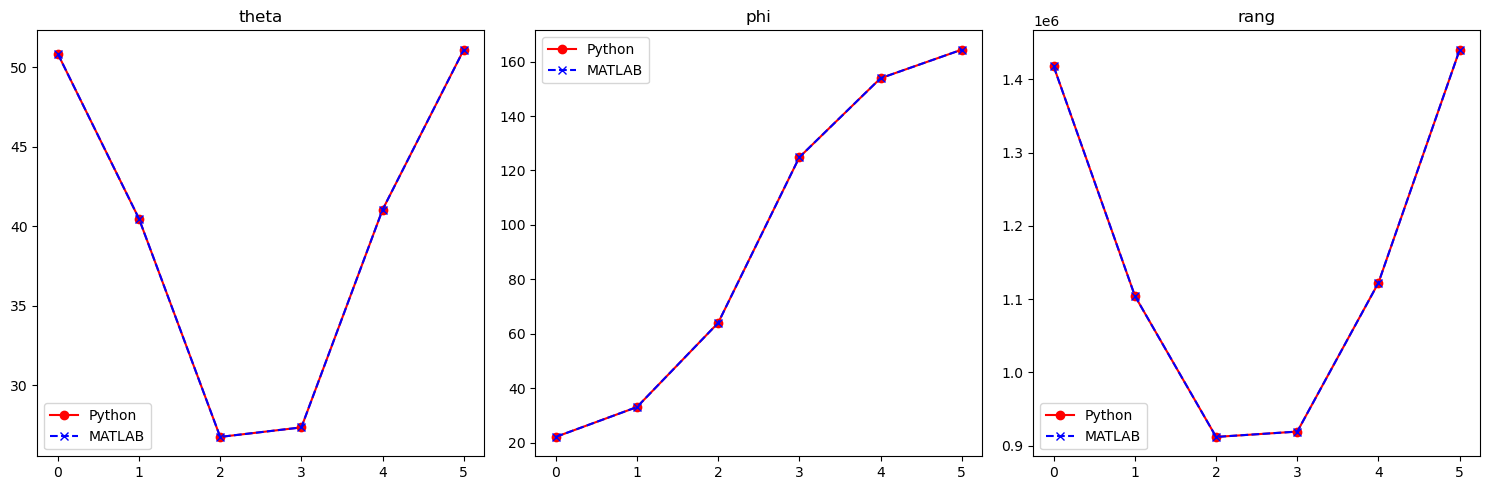

In [7]:
from Functions_cal import compare_wuchafenxi0922
compare_wuchafenxi0922()  